# SbD4Nano WP2 assertions

RDFy the correlational assertion literature review for the case: S-doped SiO2@TiO2 addition to paint formulation

## Background

Adding TiO2 NPs to paint formulation is common for the photocatalysis of  the degradation of pollutants in paint. Moreover, it is known to enhance optical properties and to scatter UV, preventing discoloration The Sulphur doping is known to improve TiO2 photocatalytic activity (https://www.sciencedirect.com/science/article/pii/S0920586110008412). The external amorphous silica layer (SiO2) is hypothesized to reduce toxicity and dustiness, sort of 'retaining' the individual particles. Since TiO2 is considered by the EU to be carcinogenic, it is crucial to try to reduce its ability to 'escape' from the paint and become toxic.

The literature search focused on:
1. Stability of the nanocomposite in possible exposure scenarios (sol-gel synthesis, weathering of the paints)
2. TiO2 safety as determined by its properties (rutile or anatase, concentration, etc.)
3. Assertions involving structure and cuntion (photocatalytic potential)
4. S-doping specific knowledge

## What's in this notebook

This notebook:
1.  Uses the Google API client library to retrieve the [spreadsheet](https://docs.google.com/spreadsheets/d/13dqwura-jSnGMVBSO7pVXfRgbPegGC7QNoSLNAFls3A/) with the curated data
2.  Describes and characterizes the curated data set. This step includes the programatic retrieval of the license type for each used publication
3.  Guides through the process of RDF-ying using `rdflib`
4.  Performs some QC SPARQL queries on the generated graphs

## Imports and configuration

In [90]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os.path
import pickle
import pandas as pd
import yaml
from rdflib import Graph, URIRef, Literal, BNode, Namespace
from rdflib.namespace import DC, RDFS, FOAF, DCTERMS, VOID, RDF, XSD, OWL
import requests

Each page in the spreadsheet is retrieved according to the range defined in the `config.yaml` config file.

In [64]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f.read())
    SCOPES = config['SCOPES']
    SPREADSHEET_ID = config['SPREADSHEET']
    RANGE_ASSERTIONS = config['ASSERTIONS']
    RANGE_MATERIALS = config['MATERIALS']
    RANGE_ASSAYS = config['ASSAYS']
    RANGE_NODE_BREAKDOWN = config['NODE_BREAKDOWN']
    RANGE_MEASUREMENT_GROUPS = config['MEASUREMENT_GROUPS']
    RANGE_QUOTES = config['QUOTES']
    EMAIL = config['EMAIL']

## Retrieve data
The following function is used over all ranges in [`config.yaml`]('config.yaml') to retrieve the following data as pandas data frames: 
- `assertions`: the _nodes_ of causal relationships supported by the `quotes` and all other supporting data
- `quotes`: the quotes stating causal relationships, together with their source and the `cito:citesAsReference` statement, if applicable
- `node_breakdown`: TBD
- `assays`: characterization of the assays realized on `materials` to observe the results that led to the formulation of `assertions`
- `measurement_groups`: characterization of the biological systems tested in the `assays`
- `materials`: characterization of the materials used in the `assays` on the `measurement_groups`

TBD: schema of the relations between tables

In [65]:
def get_google_sheet(sheet, spreadsheet_id=SPREADSHEET_ID):
    creds = None
    range_name = globals()['RANGE_{}'.format(sheet)]
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server()
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    service = build('sheets', 'v4', credentials=creds)
    gsheet = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
    values = gsheet.get('values', [])
    if not values:
        print('No data found.')
    else:
        df = pd.DataFrame(values, columns=values[0]).drop(axis=1,index=0)
        return df


In [66]:
quotes = get_google_sheet('QUOTES')
assertions = get_google_sheet('ASSERTIONS')
materials = get_google_sheet('MATERIALS')
assays = get_google_sheet('ASSAYS')
measurement_groups = get_google_sheet('MEASUREMENT_GROUPS')
node_breakdown = get_google_sheet('NODE_BREAKDOWN')

### Quotes
TBD

In [67]:
quotes.describe()

,id,quote,doi,cito:containsAssertionFrom,review,comment
count,171,170,170,170,170,22
unique,171,145,49,45,3,19
top,Q1,,https://doi.org/10.3390/nano9071041,,no,assay-syn
freq,1,26,22,121,135,3


In [68]:
quotes.sample(5)

,id,quote,doi,cito:containsAssertionFrom,review,comment
85,Q85,We found that titanium was mainly accumulated ...,https://doi.org/10.1016/j.toxlet.2008.10.001,,no,None
136,Q136,TiO2 sol–gel was prepared by hydrolysis of tit...,https://doi.org/10.1016/S0920-5861(02)00225-0,,no,assay-syn
17,Q17,larger aggregates of TiO2 NPs attach/adsorb on...,https://doi.org//10.1007/s11270-021-05219-8,,yes,agglomerated tio2 nps adsorb onto roots and bl...
32,Q32,relatively large particles tend to be less haz...,https://doi.org/10.1016/j.polymdegradstab.2009...,,yes,None
171,Q181,"The commercial TiO2 and SiO2 nanosols, after a...",https://doi.org/10.1016/S0167-2991(06)81816-1,,no,synp2


Some sample quotes:

In [69]:
print('-', '\n- '.join(list(quotes['quote'].sample(2))))

- In the series of photocatalytic tests conducted with phenol and RhB, both under UV and visible radiation, the activity shown by the TiO2NP@SiO2 materials is remarkable: all the photocatalysts are able to remove higher amount of polluting agent from the aqueous solution compared to the P25 TiO2 benchmark (Fig. 6, Fig. 7). This enhanced performance is ascribed to the new strategy employed for the synthesis of the porous TiO2NP@SiO2 materials with the purpose of embedding the TiO2 nanoparticles at the surface of the photocatalyst (as shown by TEM, Fig. 2), thus maximising their accessibility and, therefore, their photocatalytic activity.
- the total residual geopolymer of 1 and 20 days of curing’s samples is 89 and 90% for ZnO-silicate coating, 84 and 89% for TiO2-silicate coating


### Assertions
TBD

In [70]:
assertions.describe()

,Ref_quote,doi,REVIEW?,quote,s,o,s_name,p,o_name,material,assay,measurement group,material_id,assay_id,citesAsReference
count,46,46,46,46,46,46,46,46,46,46,46,46,46,33,7
unique,32,10,1,32,11,26,11,2,26,6,13,5,7,21,4
top,Q8,https://doi.org/10.3390/nano9071041,no,"While overall the toxicity in culture was low,...",N68,N97,TiO2 to SiO2 ratio (mass? stoichometry? an int...,positively_correlates,autophagy,#N/A,#N/A,#N/A,#N/A,,"https://doi.org/10.1021/la800532q,https://doi...."
freq,5,13,46,5,15,4,15,25,4,22,22,26,22,4,4


In [71]:
assertions.sample(5)

,Ref_quote,doi,REVIEW?,quote,s,o,s_name,p,o_name,material,assay,measurement group,material_id,assay_id,citesAsReference
35,Q141,https://doi.org/10.1093/toxsci/kfj197,no,"Specifically, nano-TiO2 anatase particles prod...",N74,N78,anatase crystalline phase,positively_correlates,percent cell viability,anatase TiO2,LDH release assay,A549 cells,M5,A12,None
46,Q2,https://doi.org/10.1007/s13399-023-03783-z,no,With respect to influence of different metal a...,N69,N8,"doping (organic, inorganic)",positively_correlates,crystal structure,#N/A,#N/A,#N/A,#N/A,None,None
2,Q146,https://doi.org/10.3390/nano9071041,no,A significant impact on cell viability was obs...,N68,N105,TiO2 to SiO2 ratio (mass? stoichometry? an int...,positively_correlates,necrosis,TiO2:SiO2 3:1,Hoechst 33342/propidium iodide (H/PI) staining,A549 cells,M10,A31,"https://doi.org/10.3390/ijms18010120,https://d..."
1,Q75,https://doi.org/10.3390/nano9071041,no,The size and physical properties of NPs are pa...,N25,N96,size,positively_correlates,cytoskeleton dissassembly,TiO2:SiO2 1:1,rhodamine phalloidin staining,A549 cells,M8,A30,"https://doi.org/10.1016/j.powtec.2007.02.002,h..."
42,Q170,https://doi.org/10.1016/j.ceramint.2021.12.096,no,"Interestingly, the CTS-1050, even though with ...",N25,N99,size,positively_correlates,band gap,#N/A,#N/A,#N/A,#N/A,None,None


### Materials
TBD

In [72]:
materials.describe()

,id,label,label 2,synthesis,q_synthesis,quote_synthesis,size,size_units,size_type,part,...,surface_area_units,coat,matrix,doping,ph,zeta_potential,zeta_potential_units,polidispersity_index,manufacturer,product_name
count,13,13,13,13,13,13,11,11,11,11,...,6,4,4,4,3,3,3,0,0,0
unique,11,9,10,4,8,8,9,2,5,3,...,2,1,1,2,1,3,1,0,0,0
top,M1,XX%TiO2NP@SiO2,placeholder:titanium-silica-nanocomposite,,,#N/A,,nm,,nanoparticle,...,m2/g,,,,5,40.5±0.3,mV,NaN,NaN,NaN
freq,2,2,2,9,4,4,3,8,4,7,...,3,4,4,3,3,1,3,NaN,NaN,NaN


In [73]:
materials.sample(5)

,id,label,label 2,synthesis,q_synthesis,quote_synthesis,size,size_units,size_type,part,...,surface_area_units,coat,matrix,doping,ph,zeta_potential,zeta_potential_units,polidispersity_index,manufacturer,product_name
11,M9,TiO2:SiO2 1:3,1:3 nanocomposite of TiO2 in a Silica coat,,Q155,The following commercial materials were used t...,1490.3±829,nm,hydrodynamic diameter (Z-average),nanoparticle,...,,,,,5,7.08±0.4,mV,None,None,None
12,M10,TiO2:SiO2 3:1,3:1 nanocomposite of TiO2 in a Silica coat,,Q155,The following commercial materials were used t...,147.8±2.3,nm,hydrodynamic diameter (Z-average),nanoparticle,...,,,,,5,46.1±0.3,mV,None,None,None
3,M2,,,A3,,#N/A,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13,M11,SiO2-immobilised P25 TiO2,TiO2NP@SiO2,,,#N/A,,,,nanoparticle,...,None,None,None,None,None,None,None,None,None,None
4,M3,,,,,#N/A,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### Assays
TBD

In [74]:
assays.describe()

,id,super_id,guidance/sop/protocol,material,material_label,type,short_description,e_id,endpoint_name,value,...,time_units,measurement_group_id,measurement_group_name,concentration,concentration_units,approx_from_figure,exposure_route,exposure_quantity,exposure_quantity_units,img_link
count,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,28,3,3,1
unique,34,5,3,10,8,19,12,15,14,13,...,3,4,5,6,4,2,2,1,1,1
top,A18,,,M5,rutile TiO2,Human IL-8 Enzyme Immunometric Assay,,,,,...,h,G1,A549 cells,,,n,na,486,μg,https://media.springernature.com/full/springer...
freq,2,21,29,11,12,8,22,13,12,22,...,23,15,15,25,25,30,25,3,3,1


In [75]:
assays.sample(5)

,id,super_id,guidance/sop/protocol,material,material_label,type,short_description,e_id,endpoint_name,value,...,time_units,measurement_group_id,measurement_group_name,concentration,concentration_units,approx_from_figure,exposure_route,exposure_quantity,exposure_quantity_units,img_link
11,A11,4,,M6,rutile TiO2,Chemiluminiscence of luminol ROS production,Chemiluminiscence of luminol ROS production,E9,chemiluminescence of luminol,,...,,,#N/A,,,n,na,None,None,None
21,A19,,Human IL-8 Enzyme Immunometric Assay Kit (Assa...,M5,anatase TiO2,Human IL-8 Enzyme Immunometric Assay,,E13,spectroscopy IL-8,50,...,h,G2,HDF cells,0.3,μg/ml,y,na,None,None,None
30,A26,,,M8,TiO2:SiO2 1:1,LC3B II expression by cytofluorimeter,LC3B II expression by cytofluorimeter,,,,...,h,G1,A549 cells,,,n,None,None,None,None
20,A19,,Human IL-8 Enzyme Immunometric Assay Kit (Assa...,M5,anatase TiO2,Human IL-8 Enzyme Immunometric Assay,,E13,spectroscopy IL-8,175,...,h,G2,HDF cells,3000,μg/ml,y,na,None,None,None
18,A18,,Human IL-8 Enzyme Immunometric Assay Kit (Assa...,M5,anatase TiO2,Human IL-8 Enzyme Immunometric Assay,,E13,spectroscopy IL-8,75,...,h,G1,A549 cells,3000,μg/ml,y,na,None,None,None


<AxesSubplot: >

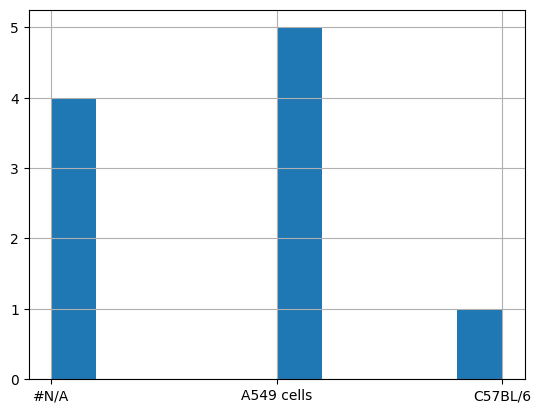

In [76]:
assays.drop_duplicates('material')['measurement_group_name'].hist()

### Measurement groups
TBD

In [77]:
measurement_groups.describe()

,id,source,type,age
count,3,3,3,1
unique,3,1,3,1
top,G1,,A549 cells,5-7 weeks
freq,1,3,1,1


In [78]:
measurement_groups

,id,source,type,age
1,G1,,A549 cells,None
2,G2,,HDF cells,None
3,G3,,C57BL/6,5-7 weeks


### node breakdown

In [79]:
node_breakdown.describe()

,node,curated,node_label,comments,predicate_to_material,used,need_term_request,IRI_enm_jvr,IRI
count,103,103,103,103,103,103,68,65,31
unique,103,2,103,9,1,2,3,38,31
top,N1,Yes,core composition,,,FALSE,,,http://purl.bioontology.org/ontology/npo#NPO_895
freq,1,65,1,95,103,69,65,25,1


In [80]:
node_breakdown.sample(5)

,node,curated,node_label,comments,predicate_to_material,used,need_term_request,IRI_enm_jvr,IRI
70,N72,No,silica coating,,,TRUE,left out,None,None
100,N107,No,colloidal stability,,,FALSE,None,None,None
38,N39,No,sedimentation rate,,,FALSE,None,None,None
5,N5,Yes,diameter,,,FALSE,,http://purl.org/obo/owl/PATO#PATO_0001334,None
64,N65,No,organic matter (in medium),,,FALSE,None,None,None


## Retrieve licenses

In [87]:
def check_open_access(doi):
    id = doi.split('.org/')[1]
    api_url = 'https://api.unpaywall.org/v2/{}?email={}'.format(id,EMAIL)
    try:
        response = requests.get(api_url).json()
        if response['is_oa'] == True:
            try:
                license = response['best_oa_location']['license']
            except:
                license = 'NA/closed'
            return True, license
        else:
            return False, 'closed'
    except Exception as e:
        print('Exception for: {}. Could not retrieve {})'.format(api_url, e))
        return 'NA'

for doi in set(assertions['doi']):
    if isinstance(doi, str) and 'https' in doi:
        is_oa = check_open_access(doi)
        if isinstance(is_oa[0], bool):
            assertions.loc[assertions['doi'] == doi, 'is_oa'] = is_oa[0]
            assertions.loc[assertions['doi'] == doi, 'license'] = is_oa[1]


Plotting the different license types, we see a majority of non-open papers:

<AxesSubplot: >

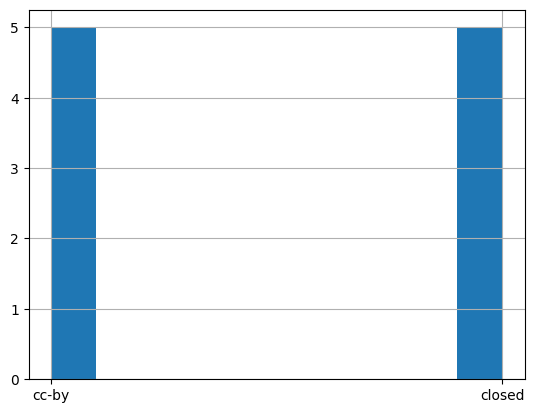

In [88]:
assertions.drop_duplicates('doi')['license'].hist()

<AxesSubplot: >

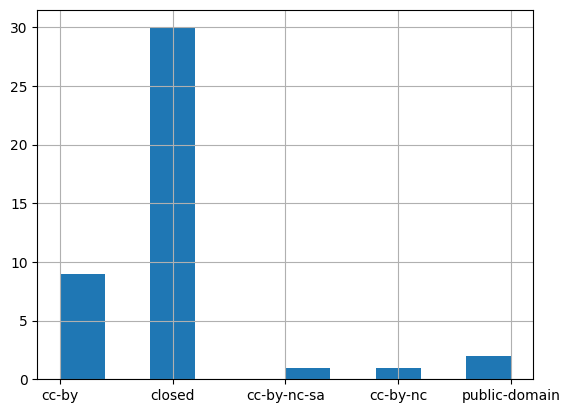

In [89]:
for doi in set(quotes['doi']):
    if isinstance(doi, str) and 'https' in doi:
        is_oa = check_open_access(doi)
        if isinstance(is_oa[0], bool):
            quotes.loc[quotes['doi'] == doi, 'is_oa'] = is_oa[0]
            quotes.loc[quotes['doi'] == doi, 'license'] = is_oa[1]
quotes.drop_duplicates('doi')['license'].hist()

## Define RDF namespaces

# TODO the config for the rdf needs to be in a separate, reusable file

# TODO define sbdbel properly (ontological modelling of stated correlations? stated effects? need to discuss)

In [84]:
sbd = Namespace('https://www.sbd4nano.eu/rdf/#')
sbdbel = Namespace('https://www.sbd4nano.eu/bel/#')
ECO = Namespace('https://evidenceontology.org/#')
kb = Namespace('https://h2020-sbd4nano.github.io/sbd-data-landscape/')
enm = Namespace('http://purl.enanomapper.org/onto/')
ncit = Namespace('http://purl.obolibrary.org/obo/NCIT')
npo = Namespace('http://purl.bioontology.org/ontology/npo#')
pato = Namespace('http://purl.org/obo/owl/PATO#')
cito = Namespace('http://purl.org/spar/cito/')
gracious = Namespace('https://h2020-sbd4nano.github.io/sbd4nano-gracious-owl/gracious.html#')
aop_event = Namespace('https://identifiers.org/aop.events/')
bio = Namespace('http://purl.jp/bio/4/id/')
sio = Namespace('http://semanticscience.org/resource/')
efo = Namespace('http://www.ebi.ac.uk/efo/')

In [85]:
g = Graph()
g.bind('dc', DC)
g.bind('rdfs', RDFS)
g.bind('foaf', FOAF)
g.bind('dcterms', DCTERMS)
g.bind('dc', DC)
g.bind('void', VOID)
g.bind('rdf', RDF)
g.bind('xsd', XSD)
g.bind('eco', ECO)
g.bind('sbd', sbd)
g.bind('sbdbel', sbdbel)
g.bind('kb', kb)
g.bind('enm', enm)
g.bind('ncit', ncit)
g.bind('npo', npo)
g.bind('pato', pato)
g.bind('cito', cito)
g.bind('gracious', gracious)
g.bind('aop_event', aop_event)
g.bind('bio', bio)
g.bind('sio', sio)
g.bind('void', VOID)
g.bind('efo', efo)
source = URIRef(f'https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}')
void_source = URIRef("https://github.com/h2020-sbd4nano/relationship_network")
g.add((void_source, RDF.type, VOID.DatasetDescription))
g.add((void_source, FOAF.page, URIRef("https://www.sbd4nano.eu/")))
g.add((void_source, DC.source, source))
g.add((void_source, DC.title, Literal("SbD4nano WP2 Causal Relationships", lang="en")))

<Graph identifier=N57be3c660f1b43618661828ddad7736c (<class 'rdflib.graph.Graph'>)>

## RDFy

### Correlations

In [86]:
for i, row in assertions.iterrows():
    # For each assertion row, find all supporting collected data
    quote_id = row['id']
    relation = URIRef("https://h2020-sbd4nano.github.io/sbd-data-landscape/_{}".format(str(row['p']))) 

    # cause (# TODO: rename to subject)
    cause = BNode()
    cause_node = node_breakdown[node_breakdown['node'] == row['s']].index.tolist()
    # TODO check modelling of asserted 'causes' (not causes if these are 'correlations' or rather 'assertions/observations')
    g.add((relation, URIRef(sbdbel + "cause"), cause))
    g.add((cause, RDFS.label, Literal(node_breakdown.node[cause_node[0]])))
    g.add((cause, OWL.sameAs, URIRef(str(node_breakdown.IRI[cause_node[0]]))))
    #g.add((cause, OWL.sameAs, URIRef(str(node_breakdown.Gracious[cause_node[0]]))))
    #g.add((cause, OWL.sameAs, URIRef(str(node_breakdown.AOPWiki[cause_node[0]]))))


    # outcome (# TODO: rename to object)
    outcome = BNode()
    outcome_node = node_breakdown[node_breakdown['node'] == row['o']].index.tolist()
    reference = row['doi']
    cites = row['citesAsReference']
    if cites:
        if ',' in cites:
            cites = ",".split(cites)
        else:
            cites = [cites]
    g.add((relation, URIRef(sbdbel + "outcome"), outcome))
    g.add((outcome, RDFS.label, Literal(node_breakdown.Node[outcome_node[0]])))
    #g.add((outcome, OWL.sameAs, URIRef(str(node_breakdown.IRI[outcome_node[0]]))))
    #g.add((outcome, OWL.sameAs, URIRef(str(node_breakdown.Gracious[outcome_node[0]]))))
    #g.add((outcome, OWL.sameAs, URIRef(str(node_breakdown.AOPWiki[outcome_node[0]]))))

    
    # relation
    g.add((relation, RDF.type, URIRef(sbd + "resource")))
    g.add((relation, RDF.type, URIRef(sbd + "CausalAssertion")))
    g.add((relation, DC.source, source))
    for cite in cites if type(cite)==list():
        g.add((relation, cito.containsAssertionFrom, cite))
    # TODO change, For now: source is a literal
    g.add((relation, sio.SIO_000299, Literal(reference)))
    g.add((relation, URIRef(sbdbel + "relationship"), URIRef(sbdbel + str(row['p']))))
    
    g.serialize(format='turtle', destination='assertions.ttl')



34    rhodamine phalloidin staining 10    TiO2:SiO2 1:1
35    Hoechst 33342/propidium iodide (H/PI) staining 12    TiO2:SiO2 3:1
37    Cytofluorometric assay 12    TiO2:SiO2 3:1
30    LC3B II expression by cytofluorimeter 10    TiO2:SiO2 1:1
30    LC3B II expression by cytofluorimeter 10    TiO2:SiO2 1:1
36    MTT assay 12    TiO2:SiO2 3:1
38    Annexin V/PI test 12    TiO2:SiO2 3:1
Series([], ) Series([], )
Series([], ) Series([], )
Series([], ) Series([], )
Series([], ) Series([], )
34    rhodamine phalloidin staining 10    TiO2:SiO2 1:1
30    LC3B II expression by cytofluorimeter 12    TiO2:SiO2 3:1
Series([], ) Series([], )
Series([], ) Series([], )
Series([], ) Series([], )
Series([], ) Series([], )
Series([], ) Series([], )
Series([], ) Series([], )
Series([], ) Series([], )
Series([], ) Series([], )
28    Comet assay 9    rutile TiO2
Series([], ) Series([], )
26    BAL 9    rutile TiO2
Series([], ) Series([], )
Series([], ) Series([], )
6    LC50 7    anatase TiO2
6    LC50 7   

## QC SPARQL Queries